# Image Captioning with transformer


- CNN과 Transformer 모델을 이용하여 만든 이미지 캡셔닝 모델

## Setup

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

C:\Users\uefi\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## 데이터 셋 경로와 라벨링 처리하기

- 농작물 질병 이미지에 대한 데이터프레임을 이용하여 데이터를 준비합니다.
- 데이터프레임에는 농작물 질병 이미지의 디렉토리 경로와 각 이미지에 대한 5개의 문장 쌍으로 이루어져 있습니다.

In [2]:

# 이미지 경로
IMAGES_PATH = r"C:\Users\uefi\Desktop\peppers"

# 이미지 사이즈
IMAGE_SIZE = (299, 299)

# 사전 사이즈
VOCAB_SIZE = 10000

# 시퀀스 최대 길이
SEQ_LENGTH = 25

# 이미지 임베딩과 토큰 임베딩의 차원
EMBED_DIM = 512

# the feed-forward network의 각 층에 들어있는 unit 개수
FF_DIM = 512

# 모델 훈련에 필요한 다른 매개변수들
BATCH_SIZE = 64   #64 / 16
EPOCHS = 30        #30 / 20
AUTOTUNE = tf.data.AUTOTUNE #하드웨어 리소스를 병렬로 매핑하여 작업 시간을 단축시키는데 사용함

## 모델 학습을 위한 데이터 준비
- 모델 학습에 필요한 구조로 데이터를 준비한다.

In [3]:
#이미지 이름과 각 이미지에 대한 5개의 캡션이 달려있는 데이터프레임 불러오기
df = pd.read_csv(r'C:\Users\uefi\Downloads\pepper_merged.csv', encoding='utf-8').drop('Unnamed: 0', axis=1)

In [4]:
df.head()

,images,captions
0,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 움푹 들어간 원형 반점이 나타나는 것으로 보아 고추탄저병으로 의심됩니다
1,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 원형 반점이 움푹 들어나는 양상을 보여 고추탄저병으로 의심됩니다
2,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 원형 반점이 나타나 고추탄저병으로 의심됩니다
3,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 원형 반점이 생긴 것으로 보아 고추탄저병으로 의심됩니다
4,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 원형 반점이 움푹 들어간 것으로 보아 고추탄저병으로 의심됩니다


In [5]:
#캡션 좌우에 각각 <start>, <end> 토큰을 부착함
text_data = []
for caption in df.captions.values:
    tx = '<start> '+ caption + ' <end>'
    text_data.append(tx)

In [6]:
text_data[:5]

['<start> 고추에 움푹 들어간 원형 반점이 나타나는 것으로 보아 고추탄저병으로 의심됩니다 <end>',
 '<start> 고추에 원형 반점이 움푹 들어나는 양상을 보여 고추탄저병으로 의심됩니다 <end>',
 '<start> 고추에 원형 반점이 나타나 고추탄저병으로 의심됩니다 <end>',
 '<start> 고추에 원형 반점이 생긴 것으로 보아 고추탄저병으로 의심됩니다 <end>',
 '<start> 고추에 원형 반점이 움푹 들어간 것으로 보아 고추탄저병으로 의심됩니다 <end>']

In [7]:
#이미지 경로를 key로, 해당 경로의 이미지에 대한 5개의 캡션 문장들을 담은 리스트를 value로 하는 딕셔너리 생성

captions_mapping = collections.defaultdict(list)
for i in range(len(df)):
    image_path = IMAGES_PATH + '\\' +df.images[i] #이미지 경로
#     print(image_path, '\n')
    captions_mapping[image_path].append(df.captions[i])
#     print(image_path_to_caption)


In [8]:
captions_mapping['C:\\Users\\uefi\\Desktop\\peppers\\V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG']

['고추에 움푹 들어간 원형 반점이 나타나는 것으로 보아 고추탄저병으로 의심됩니다',
 '고추에 원형 반점이 움푹 들어나는 양상을 보여 고추탄저병으로 의심됩니다',
 '고추에 원형 반점이 나타나 고추탄저병으로 의심됩니다',
 '고추에 원형 반점이 생긴 것으로 보아 고추탄저병으로 의심됩니다',
 '고추에 원형 반점이 움푹 들어간 것으로 보아 고추탄저병으로 의심됩니다']

In [9]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """
       캡션 데이터를 훈련, 검증 데이터셋으로 분리
    
    변수:
        caption_data (dict): 이미지 경로를 key로, 해당 경로의 이미지에 대한 5개의 캡션 문장들을 담은 리스트를 value로 하는 딕셔너리
        train_size (float): 전체 데이터에서 몇 퍼센트를 훈련 데이터셋으로 사용할 것인지를 알려주는 실수(비율)
        shuffle (bool): 데이터를 분리하기 전에 전체 데이터를 뒤섞을 것인지를 결정함. True이면 뒤섞고 False이면 그대로 둠.

    반환값:
        Traning and validation datasets as two separated dicts 두 개의 분리된 훈련 데이터셋과 검증 데이터셋
    """

    # 1. 이미지 이름을 담은 리스트 생성
    all_images = list(caption_data.keys())

    # 2. 만약 데이터를 뒤섞기로 결정했다면 무작위로 뒤섞음
    if shuffle:
        np.random.shuffle(all_images)

    # 3. 전체 데이터 개수에서 훈련 데이터로 분리하고 싶은 만큼의 비율로 훈련 데이터 개수를 계산하여 전체 데이터를 훈련데이터와 검증데이터로 분리함
    train_size = int(len(caption_data) * train_size)

    training_data = {img_name: caption_data[img_name] for img_name in all_images[:train_size]}
    validation_data = {img_name: caption_data[img_name] for img_name in all_images[train_size:]}

    # 4. 훈련데이터와 검증데이터를 반환함
    return training_data, validation_data



# 위에서 만든 함수로 전체 데이터를 훈련데이터와 검증데이터로 분리하기
train_data, valid_data = train_val_split(captions_mapping)
print("훈련 데이터 개수: ", len(train_data))
print("검증 데이터 개수: ", len(valid_data))

훈련 데이터 개수:  19330
검증 데이터 개수:  4833


## 텍스트 데이터를 벡터로 변환하기

모델에 텍스트를 학습시키기 위해 `TextVectorization`으로 텍스트를 벡터화한다.
텐서플로우의 TextVectorization을 이용하여 텍스트를 벡터로 변환하는데, 각 벡터의 요소는 텍스트 토큰의 인덱스값이다.

In [12]:
## 텍스트 전처리 예시
strip_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~" #구두점
def custom_standarization(input_string):
    a = tf.strings.regex_replace(input_string, "[%s]" % re.escape(strip_chars), "")
    return a
custom_standarization(u"hi hello ... ))) 안녕")


<tf.Tensor: shape=(), dtype=string, numpy=b'hi hello   \xec\x95\x88\xeb\x85\x95'>

In [13]:
#텍스트 전처리
strip_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~" #구두점
def custom_standarization(input_string):
    return tf.strings.regex_replace(input_string, "[%s]" % re.escape(strip_chars), "")


#텍스트 벡터 변환
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE, #VOCAB_SIZE 만큼의 고빈도 단어만 벡터화 시킨다. 
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standarization,
)
vectorization.adapt(text_data) # <start>, <end> 토큰이 부착된 캡션들을 각각 텍스트 토큰 인덱스로 구성된 벡터로 변환하도록 함.

## 이미지 증강
- 이미지 증강(image augmentation)이 필요할 때 사용하는 코드
- 이미지 뒤집기, 이미지 회전시키기, 이미지 명암 조절하기로 이미지 개수를 증강시킴

In [14]:
# 이미지 데이터 증강하기 (증강 데이터 필요할 때 사용)
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"), #이미지 뒤집기
        layers.RandomRotation(0.2), #이미지 회전시키기
        layers.RandomContrast(0.3), #이미지 명암 조절하기
    ]
)

## 모델 훈련을 위해 `tf.data.Dataset` 생성 프로세스를 구축하기

이미지와 그에 대응되는 캡션들로 구성된 쌍을 `tf.data.Dataset`을 이용하여 생성한다. 생성 프로세스는 2단계로 구성된다.
1. 이미지를 읽어온다
2. 이미지에 대한 5개의 캡션 문장을 모두 토큰화한다.



In [15]:
#이미지 읽어오는 함수
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)      # IMAGE_SIZE = (299, 299)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

#이미지 경로와 캡션을 입력하면, 이미지를 전처리하고 캡션을 벡터로 변환하도록 하는 함수
def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)

#전처리된 이미지와 벡터로 변환된 캡션으로 데이터셋을 구축하는 함수
def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions)) #이미지와 캡션을 읽어옴
    dataset = dataset.shuffle(len(images)) #데이터 뒤섞기
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# 이미지 리스트와 그 이미지에 대응되는 캡션들의 리스트를 입력하여 데이터셋 구축하기
# 훈련데이터와 검증데이터 각각에 대한 데이터셋을 구축한다.
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))


## 모델 구축하기

Our image captioning architecture consists of three models 본 이미지 캡셔닝 모델은 아래의 구조를 지닌다:

1. **CNN**: used to extract the image features 이미지 특징을 추출하는데 사용되는 모델
2. **TransformerEncoder**: 이미지에서 추출된 특징들이 트랜스포머 모델의 인코더 부분에 입력된다. 트랜스포머 모델의 인코더 부분에서는 입력된 특징에 대한 새로운 표현을 생성한다.
3. **TransformerDecoder**: 트랜스포머 모델의 디코더 부분에서는 트랜스포머 인코더의 출력값과, 텍스트 데이터를 입력값으로 받아서 캡션을 생성하는 훈련을 진행한다.

In [16]:

def get_cnn_model():
    #imagenet 이미지 데이터로 사전 훈련을 거친 ResNet101 모델로 이미지 특징을 추출
    base_model = tf.keras.applications.ResNet101(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet", 
    )
    # feature extractor의 층을 고정(layer freeze)
    # 층을 "고정" 한다는 것은 해당 계층을 훈련 과정에서 배제한다는 것으로 가중치를 업데이트하지 않는 것을 의미합니다. freezing layer의 파라미터는 학습 중이라도 파라미터가 유지됩니다.
    # 사전 학습 모델의 피처 정보를 온전히 유지하기 위해 사용합니다.
    base_model.trainable = False  #층을 고정함
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out) 
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. 이미지로부터 추출된 특징으로 임베딩 벡터 생성하기
        img_embed = self.cnn_model(batch_img)

        # 2. 인코더의 출력값과 5개의 캡션 각각을 디코더에 입력하고 각 캡션에 대한 오차와 정확도를 계산한다.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. 오차와 정확도를 갱신한다.
                batch_loss += loss
                batch_acc += acc

            # 4. 훈련 가능한 모든 가중치 리스트를 가져온다.
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. 그레이디언트 계산하기
            grads = tape.gradient(loss, train_vars)

            # 6. 훈련 가능한 모든 가중치 갱신하기
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. 오차와 정확도를 추적하는 tracker을 갱신한다
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. 오차와 정확도 값을 반환한다.
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. 이미지로부터 추출된 특징으로 임베딩 벡터 생성하기
        img_embed = self.cnn_model(batch_img)

        # 2. 인코더의 출력값과 5개의 캡션 각각을 디코더에 입력하고 각 캡션에 대한 오차와 정확도를 계산한다.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. 오차와 정확도를 갱신한다.
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. 오차와 정확도를 추적하는 tracker을 갱신한다
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. 오차와 정확도 값을 반환한다.
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # 여기에서 평가 방법들(loss_tracker, acc_tracker)을 나열해야 한다. 그래야 reset_states()가 자동으로 호출된다
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, num_captions_per_image=5, image_aug=None, #image_augmentation을 안 쓸거면 None으로 설정
)

## 모델 훈련

In [17]:

# 손실(오차)함수 정의하기 - 손실함수로 SparseCategoricalCrossentropy를 사용함
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none")

#모델 체크포인트 콜백 만들기 - 학습 도중에 에러 생겨 학습이 중단되었을 때 최근에 학습한 부분에 대한 가중치를 저장하여 나중에 그 가중치를 불러와 해당 부분부터 다시 학습할 수 있게 함
checkpoint_path = r"C:\Users\uefi\Downloads\img_caption_transformer_cp.ckpt" 

model_checkpoint = ModelCheckpoint(checkpoint_path,
                              save_weights_only=True,
                              verbose=1)

#### 저장된 체크포인트 가중치를 모델에 불러오는 방법
#### model.load_weights(checkpoint_path)



# 옵티마이저의 상태를 저장하는 것과 관련되어 경고가 발생할 수 있습니다.
# 이 경고는 (그리고 이 노트북의 다른 비슷한 경고는) 이전 사용 방식을 권장하지 않기 위함이며 무시해도 좋습니다.



# EarlyStopping 기준 설정하기
# loss가 3번 연속으로 낮아지지 않으면 학습을 중단함
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# 옵티마이저에 대한 학습률 스케줄러 설정하기
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# 학습률 스케줄 생성하기
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# 모델 컴파일하기 - 모델에 옵티마이저와 오차를 정의함
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# 모델 학습시키기
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping, model_checkpoint], #학습하면서 체크포인트로 가중치 저장
)

Epoch 1/30


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc1 in position 218: invalid start byte

## 훈련된 모델로 이미지 캡셔닝 결과 확인하기

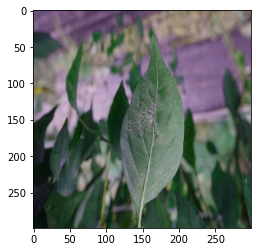

Predicted Caption:  담황색 반점무늬가 발견되어 고추흰가루병으로 사료됩니다 고추흰가루병으로 사료됩니다 고추흰가루병으로 사료됩니다 고추흰가루병으로 사료됩니다 고추흰가루병으로 사료됩니다 사료됩니다 사료됩니다 고추흰가루병으로 사료됩니다 사료됩니다 고추흰가루병으로 사료됩니다 사료됩니다 고추흰가루병으로 사료됩니다 사료됩니다


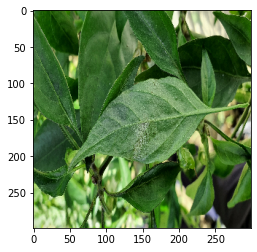

Predicted Caption:  담황색 반점무늬가 발견되어 고추흰가루병으로 사료됩니다 고추흰가루병으로 사료됩니다 고추흰가루병으로 의심됩니다 고추흰가루병으로 사료됩니다 고추흰가루병으로 사료됩니다 고추흰가루병으로 사료됩니다 고추흰가루병으로 사료됩니다 사료됩니다 고추흰가루병으로 사료됩니다 고추흰가루병으로 사료됩니다 고추흰가루병으로 사료됩니다


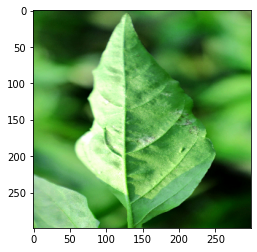

Predicted Caption:  포자가 넓게 나타나고 담황색 병무늬가 보이는 것으로 판단됩니다 고추흰가루병으로 사료됩니다 고추흰가루병으로 사료됩니다 고추흰가루병으로 사료됩니다 고추흰가루병으로 사료됩니다 고추흰가루병으로 사료됩니다 고추흰가루병으로 사료됩니다 고추흰가루병으로 사료됩니다 고추흰가루병으로 사료됩니다


In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset #검증 데이터셋에서 무작위로 이미지를 선택한다
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk #이미지를 읽어온다
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN 이미지를 CNN 모델에 전달해서 특징을 추출함
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder 추출된 특징을 트랜스포머 모델의 인코더에 입력함
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder #트랜스포머의 디코더로 이미지에 대한 캡션 문장을 생성함(사람이 아닌, 이미지 캡셔닝 모델이 만든 캡션 문장이다.)
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption) #모델이 예측한 토큰을 합쳐 캡션 문장 생성하기


# Check predictions for a few samples
generate_caption()
# generate_caption()
# generate_caption()

In [ ]:
#모델 가중치 저장
caption_model.save_weights(r"C:\Users\uefi\Desktop\img_caption_transformer_pepper_weights")

NotImplementedError: ignored

In [ ]:
#저장된 가중치를 다시 불러와서 새로운 모델 생성하기
#모델 구조가 똑같아야 가중치 불러왔을 때 오류 안 생긴다.

#저장된 가중치의 모델과 같은 구조를 지닌 모델 만들기
new_caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, num_captions_per_image=5, image_aug=None, #image_augmentation을 안 쓸거면 None으로 설정
)


#위에서 만든 모델에 저장된 가중치를 불러오기
new_caption_model.load_weights(r"C:\Users\uefi\Desktop\img_caption_transformer_pepper_weights")